In [126]:
import fastai.tabular.all as ft
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
df = pd.read_csv("data.csv", low_memory=False)#, parse_dates=['date_confirmation'])

Low Memory para dataset grandes

In [3]:
df.shape

(2676311, 33)

In [4]:
df.isna().sum()

ID                                0
age                         2098293
sex                         2096154
city                         977681
province                     452664
country                         115
latitude                         61
longitude                        61
geo_resolution                   61
date_onset_symptoms         2414712
date_admission_hospital     2560100
date_confirmation            108489
symptoms                    2674259
lives_in_Wuhan              2671973
travel_history_dates        2673700
travel_history_location     2667089
reported_market_exposure    2675242
additional_information      2630456
chronic_disease_binary            0
chronic_disease             2676096
source                       566964
sequence_available          2676299
outcome                     2368929
date_death_or_discharge     2673163
notes_for_discussion        2675671
location                    2662935
admin3                      2595877
admin2                      

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
ID                          object
age                         object
sex                         object
city                        object
province                    object
country                     object
latitude                    float64
longitude                   float64
geo_resolution              object
date_onset_symptoms         object
date_admission_hospital     object
date_confirmation           object
symptoms                    object
lives_in_Wuhan              object
travel_history_dates        object
travel_history_location     object
reported_market_exposure    object
additional_information      object
chronic_disease_binary      bool
chronic_disease             object
source                      object
sequence_available          object
outcome                     object
date_death_or_discharge     object
notes_for_discussion        object
location    

In [6]:
df.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,...,NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,...,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,...,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,...,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,...,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


In [7]:
df['outcome'].head()

0    critical condition, intubated as of 14.02.2020
1                                             death
2                                         discharge
3                                               NaN
4                                               NaN
Name: outcome, dtype: object

## Clean Data

### Select rows where outcome is not NaN

In [5]:
df[df['outcome'].notna()].shape

(307382, 33)

I'm only going to work with non-zero data in Outcome 

In [6]:
df = df[df['outcome'].notna()]

#### Clean outcome data (only death and recovered)

In [7]:
df['outcome'].value_counts()

Hospitalized                                                                202475
Recovered                                                                    93656
Deceased                                                                      5011
recovered                                                                     3659
died                                                                           916
Under treatment                                                                370
Receiving Treatment                                                            257
Alive                                                                          189
discharge                                                                      175
stable                                                                         156
stable condition                                                               133
https://www.mspbs.gov.py/covid-19.php                                          126
disc

In [8]:
df = df.loc[(df['outcome']=='died')| (df['outcome']=='Deceased') |
        (df['outcome']=='Recovered')| (df['outcome']=='recovered')|
      (df['outcome']=='stable')| (df['outcome']=='stable condition')
         ]

In [9]:
df.isna().sum()

ID                               0
age                          98124
sex                          96984
city                         14042
province                       240
country                          0
latitude                         0
longitude                        0
geo_resolution                   0
date_onset_symptoms         100160
date_admission_hospital     103423
date_confirmation               38
symptoms                    103384
lives_in_Wuhan              103478
travel_history_dates        103441
travel_history_location     103248
reported_market_exposure    103529
additional_information       97086
chronic_disease_binary           0
chronic_disease             103420
source                        9186
sequence_available          103530
outcome                          0
date_death_or_discharge     102635
notes_for_discussion        103449
location                    100986
admin3                      103526
admin2                      103211
admin1              

### Remove columns with string

In [10]:
pd.set_option('display.max_columns', None)
df.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
8667,000-1-178,20-29,female,London,Ontario,Canada,42.983611,-81.249722,point,24.01.2020,24.01.2020,31.01.2020,NaN,NaN,23.01.2020,"Wuhan City, Hubei",NaN,recovered,False,NaN,https://news.ontario.ca/mohltc/en/2020/01/ontario-confirms-third-case-of-2019-novel-coronavirus.html (b) https://news.gov.bc.ca/releases/2020HLTH0039-000294,NaN,recovered,19.02.2020,NaN,London,NaN,NaN,Ontario,Canada,5642.0,NaN,NaN
8778,000-1-179,27,male,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.847200,point,21.01.2020,06.02.2020,06.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 30; He is one of the four Singapore residents who are being investigated at NCID after attending a private business meeting at Grand Hyatt Singapore from 20 to 22 January. The meeting included participants from China, including Hubei, and the confirmed cases from Malaysia and South Korea.",False,NaN,https://www.moh.gov.sg/news-highlights/details/two-more-confirmed-cases-of-novel-coronavirus-infection-in-singapore; https://www.moh.gov.sg/news-highlights/details/three-more-confirmed-cases-of-novel-coronavirus-infection-in-singapore\nhttps://www.channelnewsasia.com/news/singapore/coronavirus-covid-19-singapore-cases-grace-assembly-of-god--12434646,NaN,recovered,14.02.2020,NaN,National Centre for Infectious Diseases,NaN,NaN,NaN,Singapore,6480.0,NaN,NaN
8890,000-1-180,50-59,male,Snohomish County,Washington,United States,48.048180,-121.696000,admin2,NaN,NaN,11.03.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://www.snohd.org/484/Novel-Coronavirus-2019,NaN,recovered,NaN,NaN,NaN,NaN,Snohomish County,Washington,United States,8209.0,NaN,NaN
9556,000-1-186,52,female,Xi'an City,Shaanxi,China,34.107270,108.787200,admin2,23.01.2020,25.01.2020,03.02.2020,NaN,yes,21.01.2020,"Xi'an City, Shaanxi",NaN,NaN,False,NaN,http://sxwjw.shaanxi.gov.cn/art/2020/2/3/art_9_67666.html,NaN,stable,NaN,NaN,NaN,NaN,Xi'an City,Shaanxi,China,9440.0,NaN,NaN
9667,000-1-187,47,female,Xi'an City,Shaanxi,China,34.107270,108.787200,admin2,25.01.2020,28.01.2020,03.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://sxwjw.shaanxi.gov.cn/art/2020/2/3/art_9_67666.html,NaN,stable,NaN,had dinner with 3 patients diagnosed on January 31,NaN,NaN,Xi'an City,Shaanxi,China,9440.0,NaN,NaN


In [11]:
df.outcome.unique()

array(['recovered', 'stable', 'died', 'Recovered', 'Deceased',
       'stable condition'], dtype=object)

In [12]:
to_delete=['additional_information', #Large text string
           'chronic_disease',
           'notes_for_discussion', #Large text strin
           'source', #Large text string
           'symptoms', #Large text string
          'ID'] #unique values, do not provide info]

In [13]:
df = df.drop(to_delete,axis=1)

### Change date format

In [14]:
df.head()

,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,chronic_disease_binary,sequence_available,outcome,date_death_or_discharge,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
8667,20-29,female,London,Ontario,Canada,42.983611,-81.249722,point,24.01.2020,24.01.2020,31.01.2020,NaN,23.01.2020,"Wuhan City, Hubei",NaN,False,NaN,recovered,19.02.2020,London,NaN,NaN,Ontario,Canada,5642.0,NaN,NaN
8778,27,male,National Centre for Infectious Diseases,NaN,Singapore,1.322098,103.847200,point,21.01.2020,06.02.2020,06.02.2020,NaN,NaN,NaN,NaN,False,NaN,recovered,14.02.2020,National Centre for Infectious Diseases,NaN,NaN,NaN,Singapore,6480.0,NaN,NaN
8890,50-59,male,Snohomish County,Washington,United States,48.048180,-121.696000,admin2,NaN,NaN,11.03.2020,NaN,NaN,NaN,NaN,False,NaN,recovered,NaN,NaN,NaN,Snohomish County,Washington,United States,8209.0,NaN,NaN
9556,52,female,Xi'an City,Shaanxi,China,34.107270,108.787200,admin2,23.01.2020,25.01.2020,03.02.2020,yes,21.01.2020,"Xi'an City, Shaanxi",NaN,False,NaN,stable,NaN,NaN,NaN,Xi'an City,Shaanxi,China,9440.0,NaN,NaN
9667,47,female,Xi'an City,Shaanxi,China,34.107270,108.787200,admin2,25.01.2020,28.01.2020,03.02.2020,NaN,NaN,NaN,NaN,False,NaN,stable,NaN,NaN,NaN,Xi'an City,Shaanxi,China,9440.0,NaN,NaN


#### Delete columns 

In [15]:
to_delete = ['date_death_or_discharge','date_onset_symptoms','travel_history_dates','sequence_available','date_admission_hospital','date_confirmation']


#to_delete = ['sequence_available']

In [16]:
df = df.drop(to_delete,axis=1)

### Set Variables names

In [17]:
df.dtypes

age                          object
sex                          object
city                         object
province                     object
country                      object
latitude                    float64
longitude                   float64
geo_resolution               object
lives_in_Wuhan               object
travel_history_location      object
reported_market_exposure     object
chronic_disease_binary         bool
outcome                      object
location                     object
admin3                       object
admin2                       object
admin1                       object
country_new                  object
admin_id                    float64
data_moderator_initials      object
travel_history_binary        object
dtype: object

In [18]:
df.isna().sum()

age                          98124
sex                          96984
city                         14042
province                       240
country                          0
latitude                         0
longitude                        0
geo_resolution                   0
lives_in_Wuhan              103478
travel_history_location     103248
reported_market_exposure    103529
chronic_disease_binary           0
outcome                          0
location                    100986
admin3                      103526
admin2                      103211
admin1                       91325
country_new                   3464
admin_id                         0
data_moderator_initials       4886
travel_history_binary          144
dtype: int64

In [19]:
df.admin3.unique()

array([nan, 'Tianzhu County', 'Huaxi District', "Yuan'an County"],
      dtype=object)

In [20]:
cat_names = ['age', 'sex', 'city',
             'province', 'country',
            'chronic_disease_binary',
             'country_new', 
            'travel_history_binary']

cont_names = ['latitude', 'longitude'] 

y_names = ['outcome']

In [21]:
#df.columns

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103531 entries, 8667 to 673607
Data columns (total 21 columns):
age                         5407 non-null object
sex                         6547 non-null object
city                        89489 non-null object
province                    103291 non-null object
country                     103531 non-null object
latitude                    103531 non-null float64
longitude                   103531 non-null float64
geo_resolution              103531 non-null object
lives_in_Wuhan              53 non-null object
travel_history_location     283 non-null object
reported_market_exposure    2 non-null object
chronic_disease_binary      103531 non-null bool
outcome                     103531 non-null object
location                    2545 non-null object
admin3                      5 non-null object
admin2                      320 non-null object
admin1                      12206 non-null object
country_new                 100067 non-null obj

In [38]:
df.outcome.unique()

array(['recovered', 'stable', 'died', 'Recovered', 'Deceased',
       'stable condition'], dtype=object)

### Create Learner

In [22]:
X = ft.range_of(df)

In [23]:
valid_cut = len(df) - 40000

In [24]:
src = ft.TabularPandas(df,
                      procs = [ft.Categorify, ft.FillMissing],
                      cat_names = cat_names,
                      cont_names = cont_names,
                      y_names = y_names, 
                       y_block = ft.CategoryBlock,
                      splits = (X[:valid_cut], X[valid_cut:])
                      )

In [25]:
dls = src.dataloaders(bs=1024)

dataloaders

In [124]:
learn = ft.tabular_learner(dls,
                          loss_func = ft.CrossEntropyLossFlat(weight=torch.tensor([0.9, 0.1, 0.7, 0.1, 0.6, 0.6]).cuda()),
                             emb_szs = {'age':8, 'sex':3, 'city':8, 'province':16, 'country':16, 
                                        'latitude':12,'longitude':12, 'chronic_disease_binary':2,
                                         'country_new':10, 'travel_history_binary':2},
                          layers = [64,128,256], #Numero de neuronas en cada capa oculta
                          config = ft.tabular_config(act_cls=nn.LeakyReLU(inplace=True)),
                           #ps(dropout), embedingdropout, sigmoide, batchnorm, activacion
                          opt_func = ft.ranger,
                           metrics = ft.accuracy)

Función de pérdida: CrossEntropyLossFlat con balanceo de peso en las clases

In [40]:
df.age.unique()

array(['20-29', '27', '50-59', '52', '47', '54', '50', '35', '37', '24',
       '76', '38', '60-69', nan, '65', '21', '64', '63', '53', '39', '71',
       '45', '42', '25', '87', '4', '2', '67', '22-80', '44', '19-77',
       '70-79', '21-72', '80-89', '70', '90-99', '92', '28', '49', '72',
       '79', '55', '66', '58', '78', '82', '85', '69', '36', '73', '81',
       '15-88', '48', '89', '61', '75', '80', '86', '84', '20', '40',
       '62', '56', '33', '60', '59', '30', '18', '15', '23', '17', '19',
       '22', '8', '14', '26', '41', '46', '34', '20-57', '29', '0.75',
       '43', '32', '13', '11', '77', '91', '74', '68', '31', '51', '90',
       '57', '0', '83', '6', '1', '3', '99', '10', '88', '16', '96', '98',
       '7', '9', '5', '94', '101', '97', '95', '12', '93'], dtype=object)

In [44]:
a = dls[0].one_batch()
#0 train
#1 test
#2 opcional

In [45]:
a

(tensor([[  0,   0,   0,  ...,   1,  14,   1],
         [  0,   0, 416,  ...,   1,  14,   1],
         [  0,   0,  55,  ...,   1,  14,   1],
         ...,
         [  0,   0, 882,  ...,   1,  14,   1],
         [  0,   0, 619,  ...,   1,  14,   1],
         [  0,   0,  10,  ...,   1,  14,   1]], device='cuda:0'),
 tensor([[28.6147, 77.2091],
         [26.2669, 73.0305],
         [19.8701, 75.3460],
         ...,
         [19.2000, 72.9667],
         [25.1259, 85.4537],
         [23.0278, 72.6003]], device='cuda:0'),
 tensor([[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]], device='cuda:0', dtype=torch.int8))

In [46]:
a[0].shape

torch.Size([1024, 8])

In [48]:
dls.bs

1024

Tamaño de lote (filas)

In [27]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(114, 8)
    (1): Embedding(3, 3)
    (2): Embedding(977, 8)
    (3): Embedding(123, 16)
    (4): Embedding(27, 16)
    (5): Embedding(3, 2)
    (6): Embedding(25, 10)
    (7): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=67, out_features=64, bias=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=64, out_features=128, bias=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): LinBnDrop(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Capas lineales -> multiplicaciones de matrices

Después de cada multiplicación se hace una activación. Negative slope en LeakyReLU es la pendiente de los números negativos en la activación.

La información del modelo se codifica en las matrices. Para que no se pierda la información al hacer la multiplicación de muchas matrices, se usan funciones de activación.

Activaciones de los modelos:
- Adentro:
> - ReLU
> - Leaky ReLU
- Output (función de activación al final del modelo):
> - Sigmoide
> - TanH


In [51]:
learn.model.cuda()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(114, 8)
    (1): Embedding(3, 3)
    (2): Embedding(977, 8)
    (3): Embedding(123, 16)
    (4): Embedding(27, 16)
    (5): Embedding(3, 2)
    (6): Embedding(25, 10)
    (7): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=67, out_features=64, bias=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=64, out_features=128, bias=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): LinBnDrop(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

#### * Modelos Lineales:
- Normalizar para que los resultdos no se vayan a infinito
- Capa Lineal (Multiplicaciones de Tensores)
- Activación

* **Tensor más grande cada bloque** 
* **Última capa del tamaño del tensor de categorías**  _Qué tan probable es que sea cada categoría_

#### Embedings:
* Lista de vectores de tamaño controlable < Fastai tiene sus heurísticas >
* Cada vector asociado a las categorías

Ejemplo
* (embeds): ModuleList(
*    (0): Embedding(114, 8)
> - 114: lista
> - tamaño del embeding que di

In [52]:
learn.model(a[0],a[1])

tensor([[-5.0540e-02, -3.7993e-01, -4.3610e-01, -7.0821e-02, -1.4428e-01,
         -1.0673e-01],
        [-2.2094e-01, -6.8163e-02, -8.3553e-02, -2.4713e-02,  2.1691e-01,
         -8.4673e-02],
        [-1.3945e-01, -1.0739e-01, -1.8762e-02, -4.1400e-03,  1.8481e-01,
         -4.0843e-04],
        ...,
        [-1.2897e-01, -2.3018e-01, -1.7434e-01,  1.2299e-02, -5.8411e-02,
          1.8897e-02],
        [-1.1696e-01, -6.4410e-02, -2.9174e-01, -1.4673e-01,  1.1902e-01,
         -1.4062e-01],
        [-7.9503e-02, -1.3875e-01,  4.6653e-02, -2.9468e-02, -3.7914e-02,
         -1.4844e-02]], device='cuda:0', grad_fn=<AddmmBackward>)

In [53]:
learn.model(a[0],a[1]).shape

torch.Size([1024, 6])

In [54]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [33]:
learn.model.layers[0][1].weight.shape

torch.Size([64, 67])

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.009120108559727669)

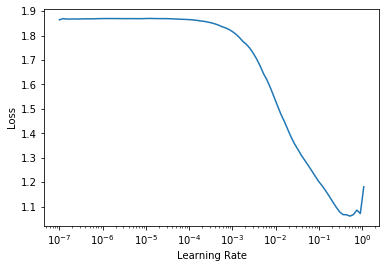

In [55]:
learn.lr_find()

In [125]:
learn.fit_one_cycle(20, 1e-3, div=2, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,1.386739,1.467391,0.842850,00:01
1,0.849622,0.821952,0.843525,00:01
2,0.586492,0.748176,0.851700,00:01
3,0.487231,0.766176,0.641000,00:01
4,0.454717,0.788149,0.852800,00:01
5,0.440821,0.754326,0.658925,00:01
6,0.434909,0.773753,0.666075,00:01
7,0.433287,0.795884,0.663525,00:01
8,0.429817,0.800501,0.666950,00:01
9,0.428116,0.804195,0.653825,00:01


# Predictions

Las predicciones llevan tres pasos:
* Codificar los datos a números usando los números de las clases que determona el modelo
* Pasar el input al modelo 
* Obtener el mayor índice correspondinte a las categorías y asociarlo a la clase.

## Método manual

In [57]:
dls.classes

{'age': ['#na#', '0', '0.75', '1', '10', '101', '11', '12', '13', '14', '15', '15-88', '16', '17', '18', '19', '19-77', '2', '20', '20-29', '20-57', '21', '21-72', '22', '22-80', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '50-59', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '60-69', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '70-79', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '80-89', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '90-99', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
 'sex': ['#na#', 'female', 'male'],
 'city': ['#na#', '71', 'Abucay', 'Addis Ababa', 'Addis Kidame', 'Adilabad', 'Afar', 'Agar Malwa', 'Agoo', 'Agra', 'Ahmedabad', 'Ahmednagar', 'Airport Quarantine', 'Aizawl', 'Ajmer', 'Akanda', 'Akola', 'Alaminos', 'Aland', 'Alappuzha', 'Aliga

In [60]:
data_pred_cat = ['23', 'male', '#na#', '#na#', '#na#', False, '#na#', '#na#']

In [61]:
data_pred_cont = [19.7060 , 101.1950]

In [68]:
data_pred_cat_2_num = []
for name, value in zip (dls.classes.keys(), data_pred_cat):
    data_pred_cat_2_num.append(dls.classes[name].map_objs([value])[0])
    

In [69]:
data_pred_cat_2_num

[25, 2, 0, 0, 0, 1, 0, 0]

In [70]:
data_pred_cat = torch.tensor(data_pred_cat_2_num).cuda()

In [71]:
data_pred_cont = torch.tensor(data_pred_cont).cuda()

In [72]:
data_pred_cont.shape

torch.Size([2])

In [73]:
data_pred_cat.shape

torch.Size([8])

In [74]:
learn.model(data_pred_cat[None],data_pred_cont[None])

tensor([[-2.1043,  1.1938, -7.0701, -0.5574, -5.4403, -6.0009]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [83]:
prediction = learn.model(data_pred_cat[None],data_pred_cont[None]).argmax().item()

In [84]:
dls.vocab[prediction]

'Recovered'

## Fastai

### Para hacer la predicción debemos pasar el input como un dataframe

In [87]:
df.iloc[0]

age                                     20-29
sex                                    female
city                                   London
province                              Ontario
country                                Canada
latitude                              42.9836
longitude                            -81.2497
geo_resolution                          point
lives_in_Wuhan                            NaN
travel_history_location     Wuhan City, Hubei
reported_market_exposure                  NaN
chronic_disease_binary                  False
outcome                             recovered
location                               London
admin3                                    NaN
admin2                                    NaN
admin1                                Ontario
country_new                            Canada
admin_id                                 5642
data_moderator_initials                   NaN
travel_history_binary                     NaN
Name: 8667, dtype: object

In [88]:
learn.predict(df.iloc[0])

(    age  sex   city  province  country  chronic_disease_binary  country_new  \
 0  19.0  1.0  526.0      89.0      6.0                     1.0          5.0   
 
    travel_history_binary   latitude  longitude  outcome  
 0                    0.0  42.983612 -81.249725      3.0  ,
 tensor(3),
 tensor([3.5748e-04, 1.4516e-04, 6.9663e-04, 9.9877e-01, 1.4571e-05, 1.2473e-05]))

In [91]:
dls.vocab[3]

'recovered'

In [102]:
dic_key_val = { name: [value] for name, value in zip (dls.classes.keys(), ['23', 'male', '#na#', '#na#', '#na#', False, '#na#', '#na#'])}
dic_key_val['latitude'] = [19.7060]
dic_key_val['longitude'] = [101.1950] 

In [107]:
pred = pd.DataFrame(dic_key_val).iloc[0]
pred

age                            23
sex                          male
city                         #na#
province                     #na#
country                      #na#
chronic_disease_binary      False
country_new                  #na#
travel_history_binary        #na#
latitude                   19.706
longitude                 101.195
Name: 0, dtype: object

In [108]:
learn.predict(pred)

(    age  sex  city  province  country  chronic_disease_binary  country_new  \
 0  25.0  2.0   0.0       0.0      0.0                     1.0          0.0   
 
    travel_history_binary   latitude  longitude  outcome  
 0                    0.0  19.705999    101.195      1.0  ,
 tensor(1),
 tensor([3.0468e-02, 8.2451e-01, 2.1244e-04, 1.4311e-01, 1.0840e-03, 6.1883e-04]))

In [112]:
dls.vocab[1]

'Recovered'

In [119]:
df.groupby('outcome').latitude.count()

outcome
Deceased             5011
Recovered           93656
died                  916
recovered            3659
stable                156
stable condition      133
Name: latitude, dtype: int64